In [ ]:
%pip install folium
%pip install ipywidgets
%pip install jupyterlab_widgets

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
import folium
from folium import Map
from folium.plugins import HeatMap
from scipy.stats import pearsonr, spearmanr

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import warnings

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# 과제 2: 배송 성과 분석 및 지역별 물류 최적화 방안

목표: 지역별 물류 최적화 방안
주제: 주문부터 배송 완료까지의 시간을 분석해서 물류 취약지역, 원인 확인 필요

배송지연 확률
배송지연이 많이 되는 구간
지역별 배송시간 차이
배송지연 건의 리뷰 점수 / 재시간에 배송된 리뷰점수 비교 (상관관계 분석)

In [3]:
from RFM import df_sellers, df_order_reviews, merge_coigp, df_product_category_name_translation, df_products, df_sellers

📌 단계별 평균 배송시간(일 단위)
purchase_to_approved     0.41
approved_to_carrier      2.90
carrier_to_customer      9.22
purchase_to_customer    12.53
dtype: float64

📌 ETA 대비 KPI
총 배송건수          108581.00
정시배송율               93.33
지연배송율                6.67
평균 지연일(지연건만)        10.49
dtype: float64

📌 지연 구간 분포 (%)
delay_days
정시/조기        93.33%
1-3일 지연       1.93%
3-7일 지연       1.84%
7-14일 지연      1.49%
14-30일 지연     1.07%
30일 초과        0.34%
Name: proportion, dtype: object


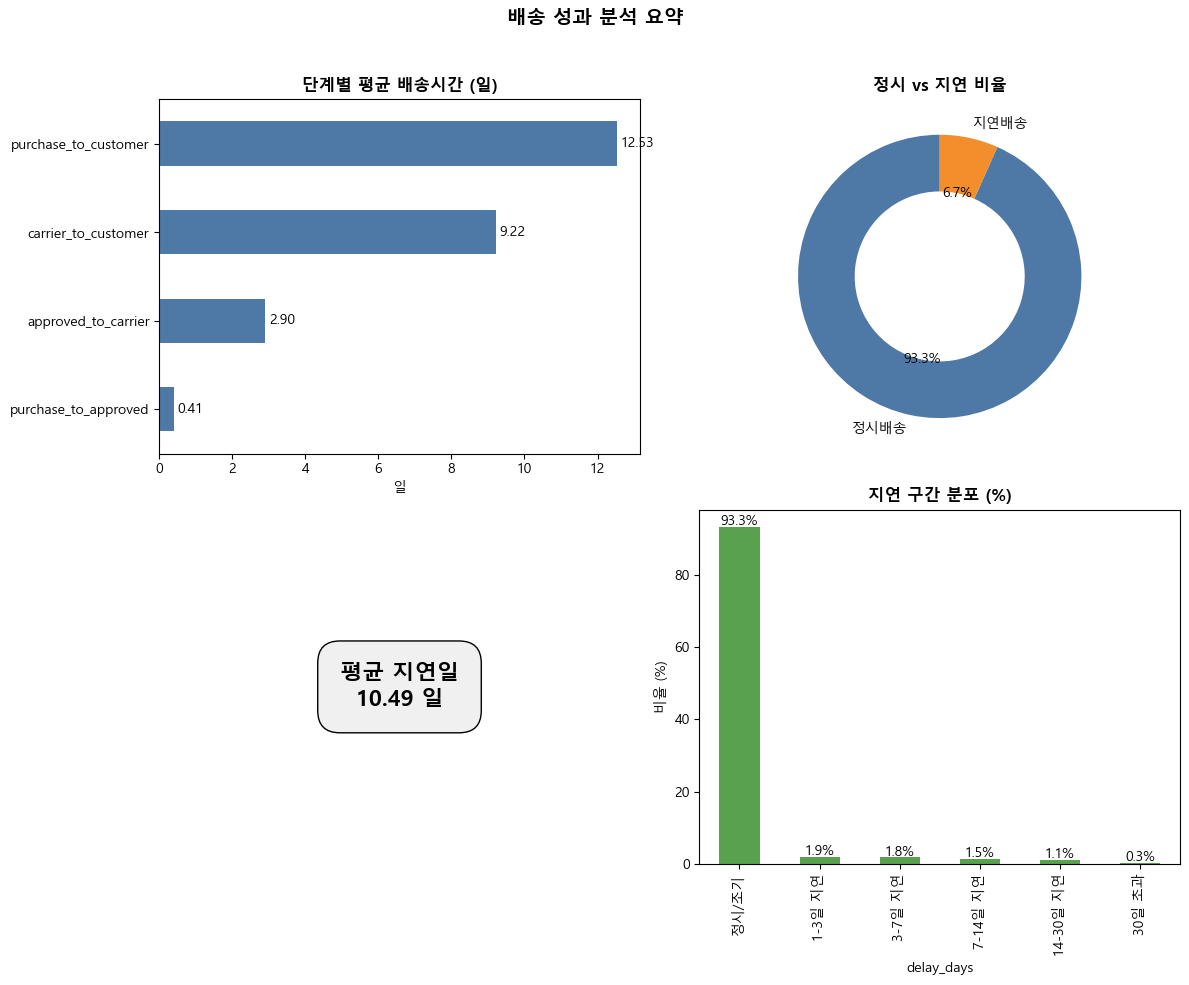

In [4]:
# 전체 지연구간 확인
# 전체 구간 (구매 ~ 고객 수령) 계산
merge_coigp["purchase_to_customer"] = (
    merge_coigp["order_delivered_customer_date"] - merge_coigp["order_purchase_timestamp"]
).dt.total_seconds() / 86400   # 일 단위

# 단계별 평균 다시 계산
step_cols = ["purchase_to_approved", "approved_to_carrier", "carrier_to_customer", "purchase_to_customer"]
step_mean = merge_coigp[step_cols].mean().round(2)
print("📌 단계별 평균 배송시간(일 단위)")
print(step_mean)

# --- 3) ETA 대비 지연일 계산 ---
# ETA는 날짜 단위 비교 권장 → floor("d") 처리
merge_coigp["delay_days"] = (
    merge_coigp["order_delivered_customer_date"].dt.floor("d")
    - merge_coigp["order_estimated_delivery_date"].dt.floor("d")
).dt.days

# 정시/지연 여부
merge_coigp["on_time"] = merge_coigp["delay_days"] <= 0

# KPI 요약
total = len(merge_coigp)
on_time = merge_coigp["on_time"].sum()
late = total - on_time
avg_delay = merge_coigp.loc[merge_coigp["delay_days"] > 0, "delay_days"].mean()

kpi = {
    "총 배송건수": total,
    "정시배송율": round(on_time / total * 100, 2),
    "지연배송율": round(late / total * 100, 2),
    "평균 지연일(지연건만)": round(avg_delay, 2)
}
print("\n📌 ETA 대비 KPI")
print(pd.Series(kpi))

# --- 4) 지연 구간 분포 ---
bins = [-np.inf, 0, 3, 7, 14, 30, np.inf]
labels = ["정시/조기", "1-3일 지연", "3-7일 지연", "7-14일 지연", "14-30일 지연", "30일 초과"]

delay_dist = pd.cut(merge_coigp["delay_days"], bins=bins, labels=labels).value_counts(normalize=True).sort_index()
delay_dist = (delay_dist * 100).round(2)

print("\n📌 지연 구간 분포 (%)")
print(delay_dist.astype(str) + "%")

## 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- (1,1) 단계별 평균 배송시간 ---
step_mean.plot(kind="barh", color="#4e79a7", ax=axes[0,0])
axes[0,0].set_title("단계별 평균 배송시간 (일)", fontsize=12, fontweight="bold")
axes[0,0].set_xlabel("일")
for i, v in enumerate(step_mean):
    axes[0,0].text(v + 0.1, i, f"{v:.2f}", va="center")

# --- (1,2) 정시 vs 지연 비율 (도넛 차트) ---
labels = ["정시배송", "지연배송"]
sizes = [kpi["정시배송율"], kpi["지연배송율"]]
colors = ["#4e79a7", "#f28e2b"]
wedges, texts, autotexts = axes[0,1].pie(
    sizes, labels=labels, autopct="%.1f%%", startangle=90,
    colors=colors, wedgeprops=dict(width=0.4)
)
axes[0,1].set_title("정시 vs 지연 비율", fontsize=12, fontweight="bold")

# --- (2,1) 평균 지연일 (KPI 카드 스타일) ---
axes[1,0].axis("off")  # 축 숨기기
axes[1,0].text(
    0.5, 0.5,
    f"평균 지연일\n{avg_delay:.2f} 일",
    ha="center", va="center", fontsize=16, fontweight="bold",
    bbox=dict(facecolor="#f0f0f0", edgecolor="black", boxstyle="round,pad=1")
)

# --- (2,2) 지연 구간 분포 (막대그래프) ---
delay_dist.plot(kind="bar", color="#59a14f", ax=axes[1,1])
axes[1,1].set_title("지연 구간 분포 (%)", fontsize=12, fontweight="bold")
axes[1,1].set_ylabel("비율 (%)")
for i, v in enumerate(delay_dist):
    axes[1,1].text(i, v + 0.5, f"{v:.1f}%", ha="center")

plt.suptitle("배송 성과 분석 요약", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

📌 주(state)별 배송 성과
                  주문수  평균_전체배송시간  정시배송율  평균_지연일
customer_state                                 
AC                 88      20.82   97.0   18.67
AL                423      24.33   79.0    9.26
AM                162      26.39   97.0   24.40
AP                 81      28.21   96.0   96.33
BA               3634      19.29   88.0   11.79
CE               1402      21.12   86.0   14.70
DF               2312      13.04   94.0    7.89
ES               2197      15.70   89.0   10.81
GO               2238      15.47   94.0   12.14
MA                787      21.74   82.0    9.87
MG              12723      12.05   96.0    8.44
MS                806      15.57   91.0    7.97
MT               1016      18.12   94.0   10.27
PA               1042      23.81   89.0   12.70
PB                574      20.68   89.0   10.08
PE               1725      18.35   91.0   11.73
PI                516      19.50   86.0   12.76
PR               5557      12.02   96.0    8.10
RJ              13970 

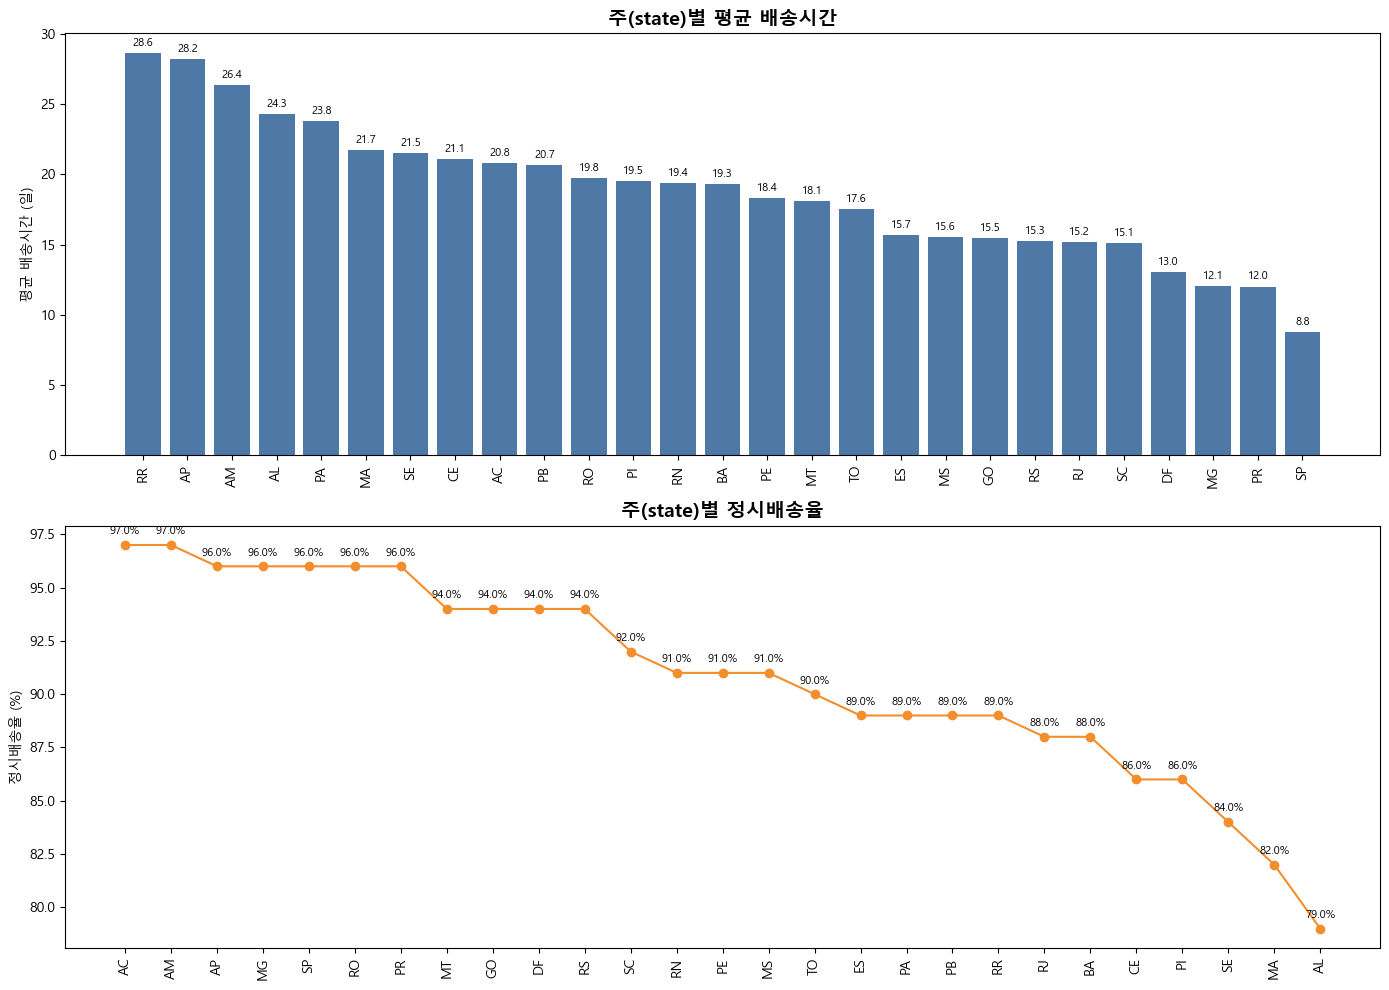

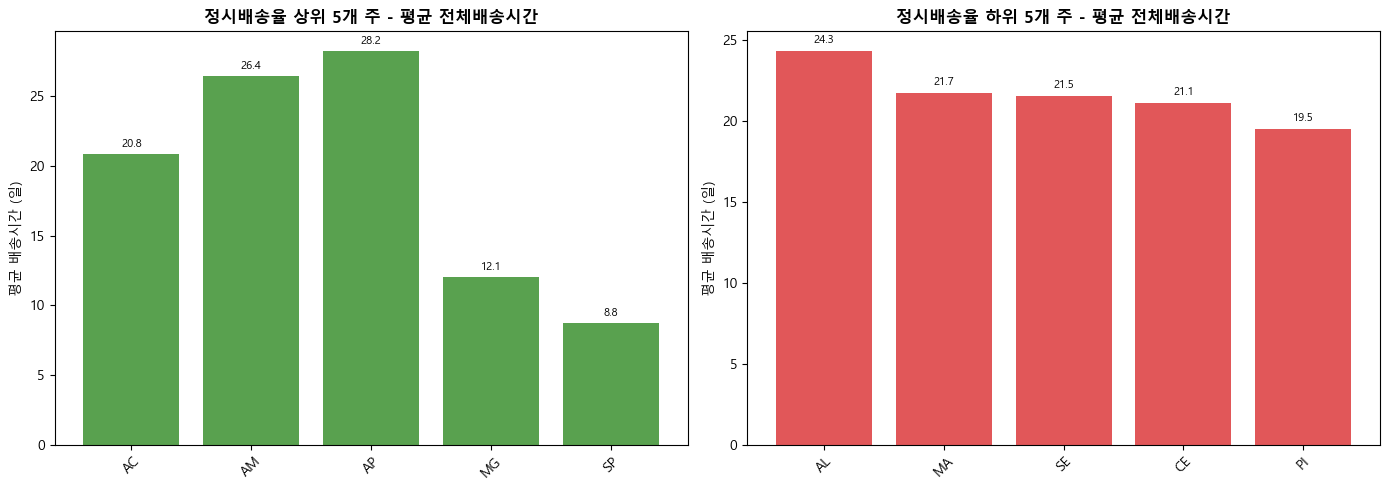

In [5]:
# 지역별 배송 성과
# 전체 구간 (구매 ~ 고객 수령) 계산
merge_coigp["purchase_to_customer"] = (
    merge_coigp["order_delivered_customer_date"] - merge_coigp["order_purchase_timestamp"]
).dt.total_seconds() / 86400   # 일 단위

# ETA 대비 지연일 계산
merge_coigp["delay_days"] = (
    merge_coigp["order_delivered_customer_date"].dt.floor("d")
    - merge_coigp["order_estimated_delivery_date"].dt.floor("d")
).dt.days

# 정시배송 여부
merge_coigp["on_time"] = merge_coigp["delay_days"] <= 0

# 주(state)별 집계
state_perf = (
    merge_coigp.groupby("customer_state")
      .agg(
          주문수=("order_id", "count"),
          평균_전체배송시간=("purchase_to_customer", "mean"),
          정시배송율=("on_time", "mean"),
          평균_지연일=("delay_days", lambda x: x[x > 0].mean())
      )
      .round(2)
)

# 정시배송율을 %로 변환
state_perf["정시배송율"] = (state_perf["정시배송율"] * 100).round(2)
print("📌 주(state)별 배송 성과")
print(state_perf)

# top 5주, 하위 5주
# 상위 5개 주 (정시배송율 내림차순, 평균 전체배송시간 오름차순)
top5_states = state_perf.sort_values(
    by=["정시배송율", "평균_전체배송시간"],
    ascending=[False, True]
).head(5)

# 하위 5개 주 (정시배송율 오름차순, 평균 전체배송시간 내림차순)
bottom5_states = state_perf.sort_values(
    by=["정시배송율", "평균_전체배송시간"],
    ascending=[True, False]
).head(5)

print("📌 배송 성과 상위 5개 주")
print(top5_states)

print("\n📌 배송 성과 하위 5개 주")
print(bottom5_states)

## 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# (1행) 주별 평균 배송시간\
state_perf_sorted = state_perf.sort_values("평균_전체배송시간", ascending=False)
axes[0].bar(state_perf_sorted.index, state_perf_sorted["평균_전체배송시간"], color="#4e79a7")
axes[0].set_title("주(state)별 평균 배송시간", fontsize=14, fontweight="bold")
axes[0].set_ylabel("평균 배송시간 (일)")
axes[0].tick_params(axis='x', rotation=90)

for i, v in enumerate(state_perf_sorted["평균_전체배송시간"]):
    axes[0].text(i, v + 0.5, f"{v:.1f}", ha="center", fontsize=8)

# (2행) 주별 정시배송율
state_perf_sorted2 = state_perf.sort_values("정시배송율", ascending=False)
axes[1].plot(state_perf_sorted2.index, state_perf_sorted2["정시배송율"], marker="o", color="#f28e2b")
axes[1].set_title("주(state)별 정시배송율", fontsize=14, fontweight="bold")
axes[1].set_ylabel("정시배송율 (%)")
axes[1].tick_params(axis='x', rotation=90)

for i, v in enumerate(state_perf_sorted2["정시배송율"]):
    axes[1].text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=8)

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# 상위 5개, 하위 5개 주 선택
top10_states = state_perf.sort_values("정시배송율", ascending=False).head(5)
bottom10_states = state_perf.sort_values("정시배송율", ascending=True).head(5)

# 1행 2열 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (왼쪽) 상위 5개 주
axes[0].bar(top10_states.index, top10_states["평균_전체배송시간"], color="#59a14f")
axes[0].set_title("정시배송율 상위 5개 주 - 평균 전체배송시간", fontsize=12, fontweight="bold")
axes[0].set_ylabel("평균 배송시간 (일)")
axes[0].tick_params(axis='x', rotation=45)

for i, v in enumerate(top10_states["평균_전체배송시간"]):
    axes[0].text(i, v + 0.5, f"{v:.1f}", ha="center", fontsize=8)

# (오른쪽) 하위 5개 주
axes[1].bar(bottom10_states.index, bottom10_states["평균_전체배송시간"], color="#e15759")
axes[1].set_title("정시배송율 하위 5개 주 - 평균 전체배송시간", fontsize=12, fontweight="bold")
axes[1].set_ylabel("평균 배송시간 (일)")
axes[1].tick_params(axis='x', rotation=45)

for i, v in enumerate(bottom10_states["평균_전체배송시간"]):
    axes[1].text(i, v + 0.5, f"{v:.1f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()

# merge

In [6]:
# df_order_reives 전처리: 최신 리뷰만 (주문당 1개), 리뷰 없는 주문: 819(약 0.7% 수준) 남김
# merge_coigp + df_order_reviews => merge_coigpr

df_order_reviews['review_creation_date'] = pd.to_datetime(df_order_reviews['review_creation_date'])
df_order_reviews = (
    df_order_reviews
        .sort_values(['order_id', 'review_creation_date'])
        .drop_duplicates(subset=['order_id'], keep='last')
)
df_coigpr = merge_coigp.merge(df_order_reviews, on='order_id', how='left')

#   - 리뷰 있는 주문: 107,762개 / 리뷰 없는 주문: 819개 / 리뷰 커버율: 99.25%
print(f"\n리뷰 점수 분포:")
print(df_coigpr['review_score'].value_counts().sort_index())

# merge_coigpr + + df_products = merge_coigprp
df_coigprp = df_coigpr.merge(
    df_products,
    on='product_id',
    how='left'
)
# - 제품 정보 있음: 107,055개 / 제품 정보 없음: 1,526개 / 매칭률: 98.59%

# df_coigprp + df_product_category_name_translation = df_logistic
df_logistic = df_coigprp.merge(
    df_product_category_name_translation,
    on='product_category_name',
    how='left'
)
#  - 영문 카테고리 있음: 107,033개 / 영문 카테고리 없음: 1,548개

# df_logistic + df_sellers 
df_logistic_final = df_logistic.merge(
    df_sellers,
    on='seller_id',
    how='left'
)


리뷰 점수 분포:
review_score
1.0    12333
2.0     3611
3.0     9093
4.0    20760
5.0    61965
Name: count, dtype: int64


# 2. 고객 리뷰와 배송 지연 영향 분석

지역별 배송 성과 (평균 배송일수, 정시율, 지연율)
배송 지연 → 리뷰 점수 하락 여부 (배송시간 vs 만족도 점수)

In [7]:
# review 컬럼 데이터 비율 확인
total_reviews = df_logistic_final['review_id'].notna().sum()
print(f"전체 리뷰: {total_reviews:,}개\n")
score_count = df_logistic_final['review_score'].notna().sum()
print(f"review_score 있음: {score_count:,}개 ({score_count/total_reviews*100:.1f}%)")
title_count = df_logistic_final['review_comment_title'].notna().sum()
print(f"review_comment_title 있음: {title_count:,}개 ({title_count/total_reviews*100:.1f}%)")
message_count = df_logistic_final['review_comment_message'].notna().sum()
print(f"review_comment_message 있음: {message_count:,}개 ({message_count/total_reviews*100:.1f}%)")

#pd.set_option('display.max_columns', None)
#df_logistic_final.columns


전체 리뷰: 107,762개

review_score 있음: 107,762개 (100.0%)
review_comment_title 있음: 12,606개 (11.7%)
review_comment_message 있음: 45,225개 (42.0%)


In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

df_cols = pd.DataFrame({
    "column_name": df_logistic_final.columns,
    "dtype": df_logistic_final.dtypes.astype(str)
})

df_cols

,column_name,dtype
customer_id,customer_id,object
customer_unique_id,customer_unique_id,object
customer_zip_code_prefix,customer_zip_code_prefix,int64
customer_city,customer_city,object
customer_state,customer_state,object
order_id,order_id,object
order_status,order_status,object
order_purchase_timestamp,order_purchase_timestamp,datetime64[ns]
order_approved_at,order_approved_at,datetime64[ns]
order_delivered_carrier_date,order_delivered_carrier_date,datetime64[ns]



🔹 Pearson  상관계수: -0.3064  (p-value: 0.0000e+00)
🔹 Spearman 상관계수: -0.2231  (p-value: 0.0000e+00)

📌 분석 데이터: 107,762건


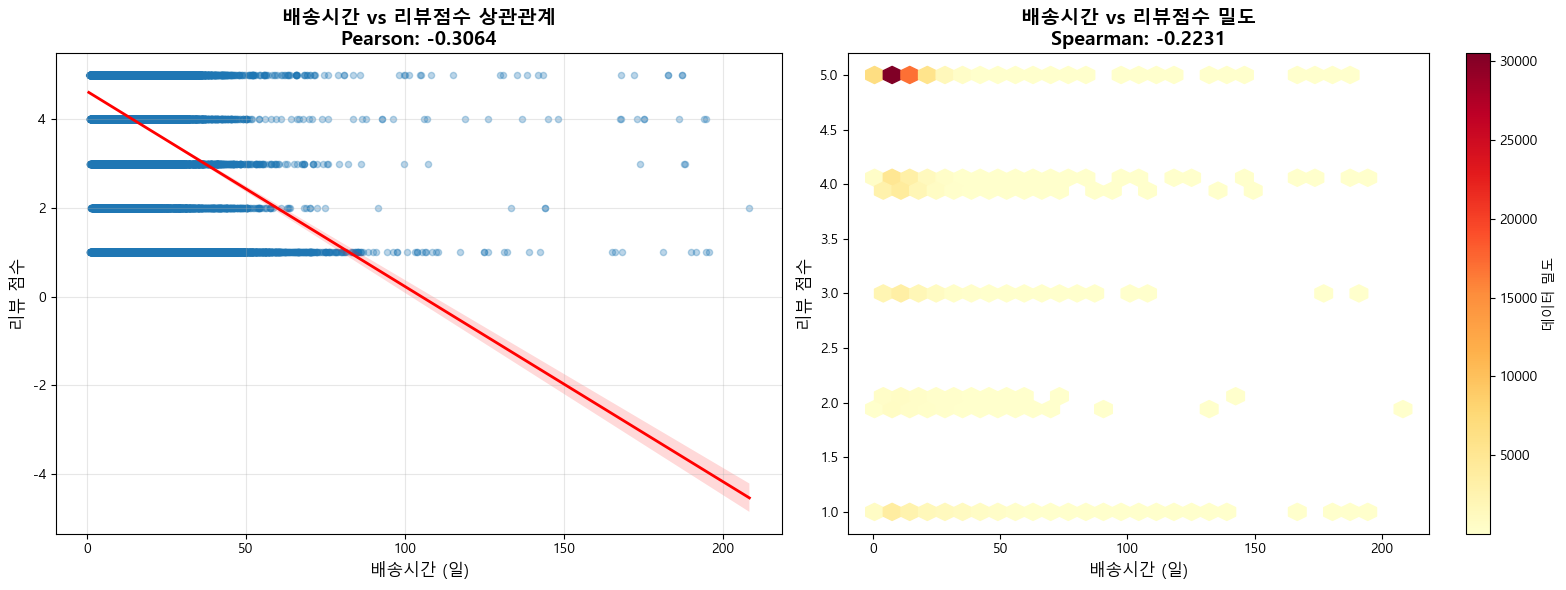

C:\Users\mumu1\AppData\Local\Temp\ipykernel_15468\522426508.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_range = df_analysis.groupby('delivery_range')['review_score'].mean()


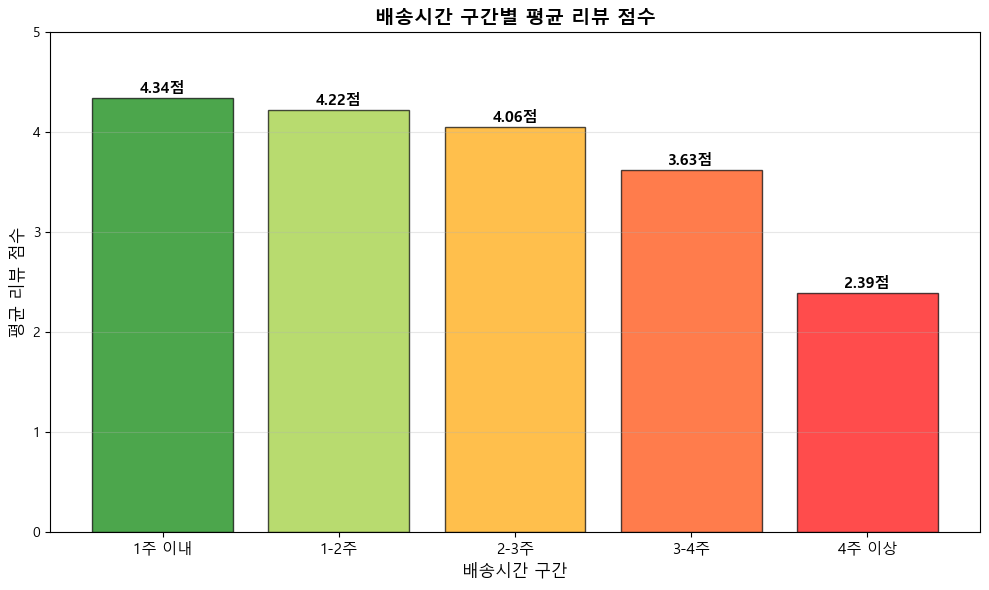

In [19]:
# 전국 단위 상관 분석 (purchase_to_customer vs review_score): 피어슨, 스피어만 방법
df_analysis = df_logistic_final[['purchase_to_customer', 'review_score']].dropna()

# 피어슨 & 스피어만 상관계수
pearson_corr, pearson_p = pearsonr(df_analysis['purchase_to_customer'], 
                                    df_analysis['review_score'])
spearman_corr, spearman_p = spearmanr(df_analysis['purchase_to_customer'], 
                                       df_analysis['review_score'])

# 전국 단위: 배송시간 vs 리뷰점수 상관관계 분석
print(f"\n🔹 Pearson  상관계수: {pearson_corr:.4f}  (p-value: {pearson_p:.4e})")
print(f"🔹 Spearman 상관계수: {spearman_corr:.4f}  (p-value: {spearman_p:.4e})")
print(f"\n📌 분석 데이터: {len(df_analysis):,}건")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ===== 1. 산점도 + 회귀선 =====
ax1 = axes[0]
sns.regplot(data=df_analysis, x='purchase_to_customer', y='review_score', 
            scatter_kws={'alpha': 0.3, 's': 20}, 
            line_kws={'color': 'red', 'linewidth': 2},
            ax=ax1)
ax1.set_title(f'배송시간 vs 리뷰점수 상관관계\nPearson: {pearson_corr:.4f}', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('배송시간 (일)', fontsize=12)
ax1.set_ylabel('리뷰 점수', fontsize=12)
ax1.grid(True, alpha=0.3)

# ===== 2. 육각형 밀도 플롯 (데이터 많을 때 효과적) =====
ax2 = axes[1]
hexbin = ax2.hexbin(df_analysis['purchase_to_customer'], 
                     df_analysis['review_score'], 
                     gridsize=30, cmap='YlOrRd', mincnt=1)
ax2.set_title(f'배송시간 vs 리뷰점수 밀도\nSpearman: {spearman_corr:.4f}', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('배송시간 (일)', fontsize=12)
ax2.set_ylabel('리뷰 점수', fontsize=12)
plt.colorbar(hexbin, ax=ax2, label='데이터 밀도')

plt.tight_layout()
plt.show()

# 배송시간 구간별 평균 리뷰 점수
df_analysis['delivery_range'] = pd.cut(df_analysis['purchase_to_customer'], 
                                        bins=[0, 7, 14, 21, 28, 100],
                                        labels=['1주 이내', '1-2주', '2-3주', '3-4주', '4주 이상'])

avg_by_range = df_analysis.groupby('delivery_range')['review_score'].mean()

# 막대 그래프
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(avg_by_range)), avg_by_range.values, 
               color=['green', 'yellowgreen', 'orange', 'orangered', 'red'], 
               alpha=0.7, edgecolor='black')
plt.xticks(range(len(avg_by_range)), avg_by_range.index, fontsize=11)
plt.ylabel('평균 리뷰 점수', fontsize=12)
plt.xlabel('배송시간 구간', fontsize=12)
plt.title('배송시간 구간별 평균 리뷰 점수', fontsize=14, fontweight='bold')
plt.ylim(0, 5)
plt.grid(axis='y', alpha=0.3)

# 값 표시
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{avg_by_range.values[i]:.2f}점', 
             ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 하위 5개 주 늦는 원인 파악, seller-customer거리, 배송료 차이 / 리뷰 점수 하락?
# 배송시간 VS 만족도 점수

# 정시배송율 상/하위 5개 주 리뷰 평균 점수 비교
# 상위 5개 주
top5_review = df_logistic_final[
    df_logistic_final['customer_state'].isin(top5_states.index)
].groupby('customer_state')['review_score'].mean().round(2)

# 하위 5개 주
bottom5_review = df_logistic_final[
    df_logistic_final['customer_state'].isin(bottom5_states.index)
].groupby('customer_state')['review_score'].mean().round(2)

print("📌 정시배송율 상위 5개 주 - 평균 리뷰 점수")
print(top5_review.sort_values(ascending=False))
print("\n📌 정시배송율 하위 5개 주 - 평균 리뷰 점수")
print(bottom5_review.sort_values(ascending=False))

print(f"\n상위 5개 주 평균: {top5_review.mean():.2f}점")
print(f"하위 5개 주 평균: {bottom5_review.mean():.2f}점")
print(f"차이: {top5_review.mean() - bottom5_review.mean():.2f}점")

# 시각화
# 각 주의 평균 좌표
state_coords = df_logistic_final.groupby('customer_state').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
})

# 상위/하위 5개 주 좌표
top5_coords = state_coords.loc[top5_states.index]
bottom5_coords = state_coords.loc[bottom5_states.index]

# 브라질 중심 좌표
brazil_center = [-14.2350, -51.9253]

# 지도 생성
m = folium.Map(
    location=brazil_center, 
    zoom_start=4,
    tiles='OpenStreetMap'
)

# 전체 주 (회색, 작게)
for state in state_coords.index:
    if state not in top5_states.index and state not in bottom5_states.index:
        folium.CircleMarker(
            location=[state_coords.loc[state, 'geolocation_lat'], 
                     state_coords.loc[state, 'geolocation_lng']],
            radius=6,
            color='gray',
            fill=True,
            fillColor='lightgray',
            fillOpacity=0.6,
            weight=1,
            popup=f"<b>{state}</b>"
        ).add_to(m)

# 상위 5개 주 (녹색, 크게)
for state in top5_coords.index:
    folium.CircleMarker(
        location=[top5_coords.loc[state, 'geolocation_lat'], 
                 top5_coords.loc[state, 'geolocation_lng']],
        radius=18,
        color='darkgreen',
        fill=True,
        fillColor='#59a14f',
        fillOpacity=0.9,
        weight=3,
        popup=f"<b>{state}</b><br>✅ 상위 5개 주<br>정시배송율: {top5_states.loc[state, '정시배송율']:.2f}%"
    ).add_to(m)
    
    # 주 이름 표시
    folium.Marker(
        location=[top5_coords.loc[state, 'geolocation_lat'], 
                 top5_coords.loc[state, 'geolocation_lng']],
        icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color: darkgreen; font-weight: bold;">{state}</div>')
    ).add_to(m)

# 하위 5개 주 (빨간색, 크게)
for state in bottom5_coords.index:
    folium.CircleMarker(
        location=[bottom5_coords.loc[state, 'geolocation_lat'], 
                 bottom5_coords.loc[state, 'geolocation_lng']],
        radius=18,
        color='darkred',
        fill=True,
        fillColor='#e15759',
        fillOpacity=0.9,
        weight=3,
        popup=f"<b>{state}</b><br>⚠️ 하위 5개 주<br>정시배송율: {bottom5_states.loc[state, '정시배송율']:.2f}%"
    ).add_to(m)
    
    # 주 이름 표시
    folium.Marker(
        location=[bottom5_coords.loc[state, 'geolocation_lat'], 
                 bottom5_coords.loc[state, 'geolocation_lng']],
        icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color: darkred; font-weight: bold;">{state}</div>')
    ).add_to(m)

# 범례 추가
legend_html = '''
<div style="position: fixed; 
            top: 10px; right: 10px; width: 200px; height: 120px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px">
<p><span style="color: #59a14f;">●</span> 정시배송율 상위 5개 주</p>
<p><span style="color: #e15759;">●</span> 정시배송율 하위 5개 주</p>
<p><span style="color: lightgray;">●</span> 기타 주</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))
m


📌 정시배송율 상위 5개 주 - 평균 리뷰 점수
customer_state
SP    4.18
PR    4.15
AC    4.14
MG    4.12
AM    4.12
Name: review_score, dtype: float64

📌 정시배송율 하위 5개 주 - 평균 리뷰 점수
customer_state
PI    3.97
SE    3.90
CE    3.88
AL    3.84
MA    3.76
Name: review_score, dtype: float64

상위 5개 주 평균: 4.14점
하위 5개 주 평균: 3.87점
차이: 0.27점


In [10]:
# 전체 주 배송시간 지도 시각화

# 주별 평균 배송시간 및 좌표
state_delivery = df_logistic_final.groupby('customer_state').agg({
    'purchase_to_customer': 'mean',
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).round(2)

# 배송시간 범위
min_time = state_delivery['purchase_to_customer'].min()
max_time = state_delivery['purchase_to_customer'].max()

# 지도 생성
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

# 색상 함수
def get_color(delivery_time, min_val, max_val):
    normalized = (delivery_time - min_val) / (max_val - min_val)
    if normalized < 0.25:
        return '#59a14f'  # 녹색 (빠름)
    elif normalized < 0.5:
        return '#76b947'  # 연두
    elif normalized < 0.75:
        return '#f28e2b'  # 주황
    else:
        return '#e15759'  # 빨강 (느림)

# 모든 주 표시
for state in state_delivery.index:
    time = state_delivery.loc[state, 'purchase_to_customer']
    color = get_color(time, min_time, max_time)
    
    folium.CircleMarker(
        location=[state_delivery.loc[state, 'geolocation_lat'], 
                 state_delivery.loc[state, 'geolocation_lng']],
        radius=10,
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.8,
        weight=2,
        popup=f"<b>{state}</b><br>평균 배송시간: {time:.1f}일"
    ).add_to(m)
    
    # 주 이름 표시
    folium.Marker(
        location=[state_delivery.loc[state, 'geolocation_lat'], 
                 state_delivery.loc[state, 'geolocation_lng']],
        icon=folium.DivIcon(html=f'<div style="font-size: 9pt; font-weight: bold;">{state}</div>')
    ).add_to(m)

# 범례
legend_html = f'''
<div style="position: fixed; top: 10px; right: 10px; width: 220px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:12px; padding: 10px">
<p style="margin:5px"><b>평균 배송시간 (일)</b></p>
<p style="margin:5px"><span style="color: #59a14f;">●</span> {min_time:.1f} ~ {min_time + (max_time-min_time)*0.25:.1f}일 (빠름)</p>
<p style="margin:5px"><span style="color: #76b947;">●</span> {min_time + (max_time-min_time)*0.25:.1f} ~ {min_time + (max_time-min_time)*0.5:.1f}일</p>
<p style="margin:5px"><span style="color: #f28e2b;">●</span> {min_time + (max_time-min_time)*0.5:.1f} ~ {min_time + (max_time-min_time)*0.75:.1f}일</p>
<p style="margin:5px"><span style="color: #e15759;">●</span> {min_time + (max_time-min_time)*0.75:.1f} ~ {max_time:.1f}일 (느림)</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

m.save('brazil_all_states_delivery.html')
display(m)